<a href="https://colab.research.google.com/github/ayushhh1010/BrainInjury_CTScan/blob/main/Intracranial_Hemorrhage_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Imports & optional dependencies

In [3]:
!pip install torch torchvision pydicom opencv-python scikit-learn matplotlib
# Optional:
!pip install timm thop


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.7 MB/s eta 0:00:00


In [14]:
import os
import sys
import math
import csv
import time
import json
import argparse
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import pydicom
import cv2

from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve , auc
)
import matplotlib.pyplot as plt

# Optional deps
try:
    import timm
except Exception:
    timm = None

try:
    from thop import profile as thop_profile
except Exception:
    thop_profile = None


Global Settings + Dataset Path

In [6]:
# ----------------------------
# Block 2: Global Settings
# ----------------------------

# Path to your dataset (root with 6 subfolders: 0..5)
DATASET_ROOT = "/content/drive/MyDrive/Brain CT Hemorrhage Detection"

# Number of classes (0=No hemorrhage, 1=Epidural, 2=Intraparenchymal,
# 3=Intraventricular, 4=Subarachnoid, 5=Subdural)
NUM_CLASSES = 6

# Image input size for CNN models
IMG_SIZE = 224

# Training hyperparameters (can be adjusted later)
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


Dataset Loader

In [7]:
# ----------------------------
# Block 3: Dataset Loader
# ----------------------------
class SliceDataset(Dataset):
    def __init__(self, root: str, transform=None):
        """
        root: dataset root folder containing 6 subfolders (0..5).
        transform: optional preprocessing transforms (unused here, can add later).
        """
        self.samples = []
        for label in range(NUM_CLASSES):
            folder = os.path.join(root, str(label))
            for f in os.listdir(folder):
                if f.endswith(".dcm"):
                    self.samples.append((os.path.join(folder, f), label))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int):
        path, label = self.samples[idx]

        # Read dicom file
        ds = pydicom.dcmread(path)
        img = ds.pixel_array.astype(np.float32)

        # ---- CT Windowing (brain window 0-80 HU) ----
        img = np.clip(img, 0, 80)
        img = (img - img.min()) / (img.max() - img.min() + 1e-5)

        # ---- Resize ----
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # ---- Convert grayscale → 3-channel ----
        img = np.stack([img, img, img], axis=0)

        # ---- Tensor ----
        img = torch.tensor(img, dtype=torch.float32)

        return img, label


CNN Architectures

In [8]:
# ----------------------------
# Block 4: CNN Architectures
# ----------------------------
def get_cnn(model_name: str, num_classes: int = NUM_CLASSES):
    if model_name == "densenet121":
        model = torch.hub.load("pytorch/vision:v0.14.0", "densenet121", pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "densenet169":
        model = torch.hub.load("pytorch/vision:v0.14.0", "densenet169", pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "seresnext101":
        if timm is None:
            raise ImportError("timm library not installed, required for SE-ResNeXt101")
        model = timm.create_model("seresnext101_32x4d", pretrained=True, num_classes=num_classes)

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model


Sequence Models with GRU

In [9]:
# ----------------------------
# Block 5: GRU-based Sequence Models
# ----------------------------
class CNN_GRU(nn.Module):
    def __init__(self, backbone: nn.Module, hidden_size: int = 256, num_classes: int = NUM_CLASSES):
        super().__init__()
        self.backbone = backbone
        if hasattr(backbone, "classifier"):   # DenseNet case
            feat_dim = backbone.classifier.in_features
            backbone.classifier = nn.Identity()
        else:
            feat_dim = backbone.get_classifier().in_features
            backbone.reset_classifier(0)

        self.gru = nn.GRU(input_size=feat_dim, hidden_size=hidden_size,
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):  # x: [B,T,3,H,W]
        B,T,C,H,W = x.shape
        feats = []
        for t in range(T):
            f = self.backbone(x[:,t])   # [B,feat_dim]
            feats.append(f.unsqueeze(1))
        feats = torch.cat(feats, dim=1)       # [B,T,feat_dim]
        _, h = self.gru(feats)                # [2,B,H]
        h = torch.cat([h[0], h[1]], dim=1)    # [B,2H]
        return self.fc(h)


Training & Evaluation Utilities

In [10]:
# ----------------------------
# Block 6: Training Utilities
# ----------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, n = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*imgs.size(0)
        correct += outputs.argmax(1).eq(labels).sum().item()
        n += labels.size(0)
    return total_loss/n, correct/n

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, n = 0, 0, 0
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            correct += outputs.argmax(1).eq(labels).sum().item()
            n += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())
            y_prob.extend(F.softmax(outputs,1).cpu().numpy())
    return total_loss/n, correct/n, np.array(y_true), np.array(y_pred), np.array(y_prob)


Metrics & Plots

In [11]:
# ----------------------------
# Block 7: Metrics & Visualization
# ----------------------------
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.yticks(range(len(classes)), classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_roc_prc(y_true, y_prob, n_classes=NUM_CLASSES):
    # ROC Curve
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true==i, y_prob[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC={roc_auc[i]:.2f})")
    plt.plot([0,1],[0,1],"k--")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # PRC Curve
    for i in range(n_classes):
        p, r, _ = precision_recall_curve(y_true==i, y_prob[:,i])
        ap = average_precision_score(y_true==i, y_prob[:,i])
        plt.plot(r,p,label=f"Class {i} (AP={ap:.2f})")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()


FLOPs & Latency

In [12]:
# ----------------------------
# Block 8: Model Profiling
# ----------------------------
def profile_model(model):
    dummy = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(DEVICE)
    if thop_profile:
        flops, params = thop_profile(model, inputs=(dummy,))
        print(f"FLOPs: {flops/1e9:.2f} GFLOPs, Params: {params/1e6:.2f}M")
    else:
        print("THOP not installed, skipping FLOPs")

    # Latency test
    model.eval()
    start = time.time()
    for _ in range(50):
        _ = model(dummy)
    end = time.time()
    print(f"Latency per image: {(end-start)/50:.4f} sec")


Main Training Loop

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.14.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 2.90 GFLOPs, Params: 6.96M
Latency per image: 0.0181 sec
Epoch 1: Train Acc=0.34, Val Acc=0.38
Epoch 2: Train Acc=0.45, Val Acc=0.39
Epoch 3: Train Acc=0.55, Val Acc=0.40
Epoch 4: Train Acc=0.68, Val Acc=0.44
Epoch 5: Train Acc=0.80, Val Acc=0.46
Epoch 6: Train Acc=0.89, Val Acc=0.44
Epoch 7: Train Acc=0.93, Val Acc=0.48
Epoch 8: Train Acc=0.95, Val Acc=0.47
Epoch 9: Train Acc=0.97, Val Acc=0.47
Epoch 10: Train Acc=0.97, Val Acc=0.

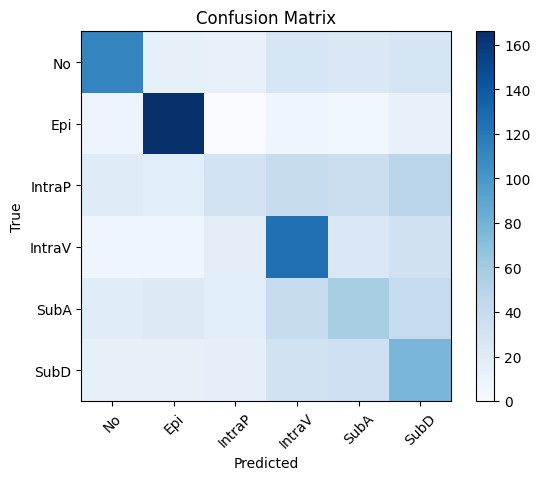

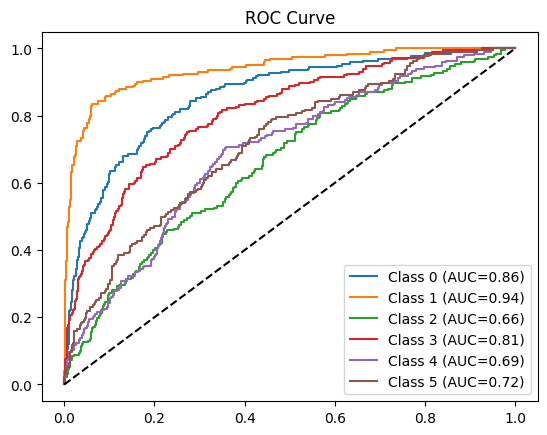

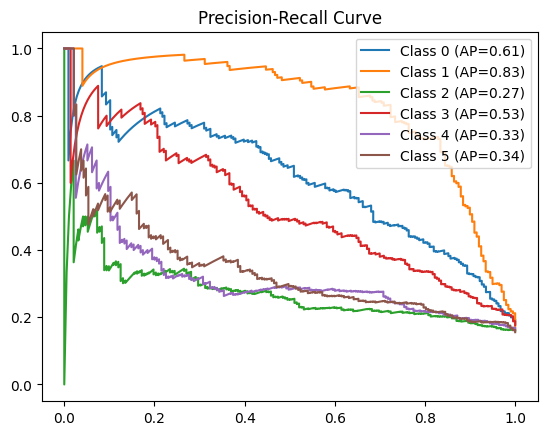

In [15]:
# ----------------------------
# Block 9: Main Training Loop
# ----------------------------
def main():
    # Dataset split
    dataset = SliceDataset(DATASET_ROOT)
    train_len = int(0.8*len(dataset))
    val_len = len(dataset) - train_len
    train_set, val_set = random_split(dataset, [train_len, val_len])

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE)

    # Model
    model = get_cnn("densenet121").to(DEVICE)   # change model here
    profile_model(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, y_true, y_pred, y_prob = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}")

    # Metrics
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred, classes=["No","Epi","IntraP","IntraV","SubA","SubD"])
    plot_roc_prc(y_true, y_prob)

if __name__ == "__main__":
    main()
